In [67]:
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display

# Initialize variables
def taxill(periods = 30, beginning_balance = 1000, beginning_cost = 0, div_rate = 0.33, st_tax = 0.37, lt_tax = 0.20, investment_return_rate = 0.07, port_turnover = 0.25):

    if beginning_cost is None: 
        beginning_cost = beginning_balance
    
    benchmark_cost = beginning_cost
    
    lt_tax_adj = lt_tax * (1 - port_turnover)
    st_tax_adj = st_tax * port_turnover

    # Preallocate lists with fixed size
    beginning_balances = [0] * periods
    investment_returns = [0] * periods
    div_incs = [0] * periods
    beginning_cost_basis = [0] * periods
    realized_gls = [0] * periods
    tax_costs = [0] * periods
    ending_cost_basis = [0] * periods
    ending_balances = [0] * periods

    benchmark_ending_balances = [0] * periods  # For the benchmark with zero turnover

    # Loop for the specified number of periods
    for i in range(periods):
        # Main portfolio calculations
        beginning_balances[i] = beginning_balance
        beginning_cost_basis[i] = beginning_cost
    
        investment_return = beginning_balance * investment_return_rate
        investment_returns[i] = investment_return
    
        div_inc = investment_return * div_rate
        div_incs[i] = div_inc
    
        realized_gl = (investment_return - div_inc) * port_turnover / 2 + (beginning_balance - beginning_cost) * port_turnover
        realized_gls[i] = realized_gl
    
        tax_cost = div_inc * lt_tax + realized_gl * lt_tax_adj + realized_gl * st_tax_adj
        tax_costs[i] = tax_cost
    
        ending_cost = beginning_cost + realized_gl + div_inc - (div_inc * lt_tax)
        ending_cost_basis[i] = ending_cost
    
        ending_balance = beginning_balance + investment_return - tax_cost
        ending_balances[i] = ending_balance
    
        # Update for next period
        beginning_balance = ending_balance
        beginning_cost = ending_cost

        # Benchmark calculations (with zero turnover)
        benchmark_investment_return = benchmark_cost * investment_return_rate
        benchmark_div_inc = benchmark_investment_return * div_rate
    
        # No realized gain/loss, hence no taxes on gains
        benchmark_tax_cost = benchmark_div_inc * lt_tax
        benchmark_end_cost = benchmark_cost + benchmark_div_inc - (benchmark_div_inc * lt_tax)
    
        benchmark_ending_balance = benchmark_cost + benchmark_investment_return - benchmark_tax_cost
        benchmark_ending_balances[i] = benchmark_ending_balance
    
        # Update for next period
        benchmark_cost = benchmark_ending_balance

    # Calculate the additional information for the summary table
    end_val_dif = abs(ending_balances[-1] - benchmark_ending_balances[-1])
    pat_perf = ((ending_balances[-1] / beginning_balances[0])**(1/periods))-1
    bat_perf = ((benchmark_ending_balances[-1] / beginning_balances[0])**(1/periods))-1

    # Required Breakeven Performance Calculation
    required_return_rate = investment_return_rate
    tolerance = 1e-6  # Convergence tolerance
    max_iterations = 1000
    for _ in range(max_iterations):
        test_balance = beginning_balances[0]
        test_cost = beginning_balances[0]
    
        for _ in range(periods):
            test_return = test_balance * required_return_rate
            test_div_inc = test_return * div_rate
            test_realized_gl = (test_return - test_div_inc) * port_turnover / 2 + (test_balance - test_cost) * port_turnover
            test_tax_cost = test_div_inc * lt_tax + test_realized_gl * lt_tax_adj + test_realized_gl * st_tax_adj
            test_cost += test_realized_gl + test_div_inc - (test_div_inc * lt_tax)
            test_balance += test_return - test_tax_cost
    
        if abs(test_balance - benchmark_ending_balances[-1]) < tolerance:
            break
    
        # Adjust the return rate for the next iteration
        if test_balance < benchmark_ending_balances[-1]:
            required_return_rate += 0.0001  # Increase the rate slightly
        else:
            required_return_rate -= 0.0001  # Decrease the rate slightly

    req_alpha = required_return_rate - bat_perf
    
    # Create a DataFrame
    df = pd.DataFrame({
        'Beginning Balance': beginning_balances,
        'Investment Return': investment_returns,
        'Dividend Income': div_incs,
        'Beginning Cost Basis': beginning_cost_basis,
        'Realized Gain/Loss': realized_gls,
        'Ending Cost Basis': ending_cost_basis,
        'Tax Cost': tax_costs,
        'Ending Balance': ending_balances,
        'Benchmark Ending Balance (0 Turnover)': benchmark_ending_balances
    })

    """df['Beginning Balance'] =  df['Beginning Balance'].apply(lambda x: "${:,.2f}".format(x))
    df['Investment Return'] =  df['Investment Return'].apply(lambda x: "${:,.2f}".format(x))
    df['Dividend Income'] =  df['Dividend Income'].apply(lambda x: "${:,.2f}".format(x))
    df['Beginning Cost Basis'] =  df['Beginning Cost Basis'].apply(lambda x: "${:,.2f}".format(x))
    df['Realized Gain/Loss'] = df['Realized Gain/Loss'].apply(lambda x: "${:,.2f}".format(x)) 
    df['Ending Cost Basis'] =  df['Ending Cost Basis'].apply(lambda x: "${:,.2f}".format(x))
    df['Tax Cost'] =  df['Tax Cost'].apply(lambda x: "${:,.2f}".format(x))
    df['Ending Balance'] =  df['Ending Balance'].apply(lambda x: "${:,.2f}".format(x))
    df['Benchmark Ending Balance (0 Turnover)'] = df['Benchmark Ending Balance (0 Turnover)'].apply(lambda x: "${:,.2f}".format(x))"""

    df1 = pd.DataFrame({
        'Ending Balance': [ending_balances[-1]],
        'Benchmark Ending Balance (0 Turnover)': [benchmark_ending_balances[-1]],
        'Ending Value Difference': [end_val_dif],
        'Portfolio Annualized After Tax Performance': [pat_perf], 
        'Benchmark Annualized After Tax Performance': [bat_perf], 
        'Portfolio Required Breakeven Performance': [required_return_rate],
        'Portfolio Required Annualized Alpha': [req_alpha],
    })

    df1['Ending Balance'] = df1['Ending Balance'].apply(lambda x: "${:,.2f}".format(x))
    df1['Ending Value Difference'] = df1['Ending Value Difference'].apply(lambda x: "${:,.2f}".format(x))
    df1['Benchmark Ending Balance (0 Turnover)'] = df1['Benchmark Ending Balance (0 Turnover)'].apply(lambda x: "${:,.2f}".format(x))

    # Format columns as percentage
    df1['Portfolio Annualized After Tax Performance'] = df1['Portfolio Annualized After Tax Performance'].apply(lambda x: "{:.2%}".format(x))
    df1['Benchmark Annualized After Tax Performance'] = df1['Benchmark Annualized After Tax Performance'].apply(lambda x: "{:.2%}".format(x))
    df1['Portfolio Required Breakeven Performance'] = df1['Portfolio Required Breakeven Performance'].apply(lambda x: "{:.2%}".format(x))
    df1['Portfolio Required Annualized Alpha'] = df1['Portfolio Required Annualized Alpha'].apply(lambda x: "{:.2%}".format(x))
    df1.set_index("Ending Balance", inplace = True)
    
    # Plot the results
    plt.figure(figsize=(10, 6))
    plt.plot(df['Ending Balance'], marker='o', linestyle='-', color='b', label='Portfolio with Turnover')
    plt.plot(df['Benchmark Ending Balance (0 Turnover)'], marker='o', linestyle='--', color='r', label='Benchmark (0 Turnover)')
    plt.title('Ending Balance Over Periods')
    plt.xlabel('Period')
    plt.ylabel('Ending Balance')
    plt.grid(True)
    plt.legend()
    plt.show()
    return display(df, df1)


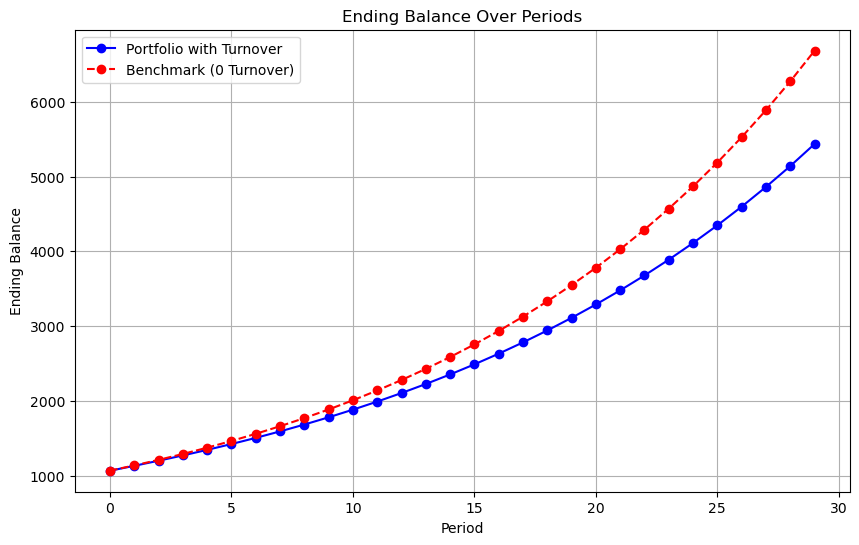

,Beginning Balance,Investment Return,Dividend Income,Beginning Cost Basis,Realized Gain/Loss,Ending Cost Basis,Tax Cost,Ending Balance,Benchmark Ending Balance (0 Turnover)
0,1000.000000,70.000000,23.100000,1000.000000,5.862500,1024.342500,6.041656,1063.958344,1065.380000
1,1063.958344,74.477084,24.577438,1024.342500,16.141417,1060.145867,8.829781,1129.605647,1135.034544
2,1129.605647,79.072395,26.093890,1060.145867,23.987258,1105.008237,11.035688,1197.642354,1209.243103
3,1197.642354,83.834965,27.665538,1105.008237,30.179707,1157.320375,12.851687,1268.625632,1288.303417
4,1268.625632,88.803794,29.305252,1157.320375,35.263632,1216.028209,14.412481,1343.016945,1372.532694
5,1343.016945,94.011186,31.023691,1216.028209,39.620621,1280.467783,15.812739,1421.215392,1462.268882
6,1421.215392,99.485077,32.830076,1280.467783,43.518778,1350.250621,17.119319,1503.581151,1557.872021
7,1503.581151,105.250681,34.732725,1350.250621,47.147377,1425.184178,18.379784,1590.452048,1659.725694
8,1590.452048,111.331643,36.739442,1425.184178,50.640993,1505.216724,19.628329,1682.155362,1768.238560
9,1682.155362,117.750875,38.857789,1505.216724,54.096295,1590.399250,20.889909,1779.016328,1883.845997


,Benchmark Ending Balance (0 Turnover),Ending Value Difference,Portfolio Annualized After Tax Performance,Benchmark Annualized After Tax Performance,Portfolio Required Breakeven Performance,Portfolio Required Annualized Alpha
Ending Balance,,,,,,
"$5,436.94","$6,685.54","$1,248.60",5.81%,6.54%,7.86%,1.32%


In [69]:
taxill(periods = 30, beginning_balance = 1000, beginning_cost= 1000, div_rate = 0.33, st_tax = 0.37, lt_tax = 0.20, investment_return_rate = 0.07, port_turnover = 0.25)

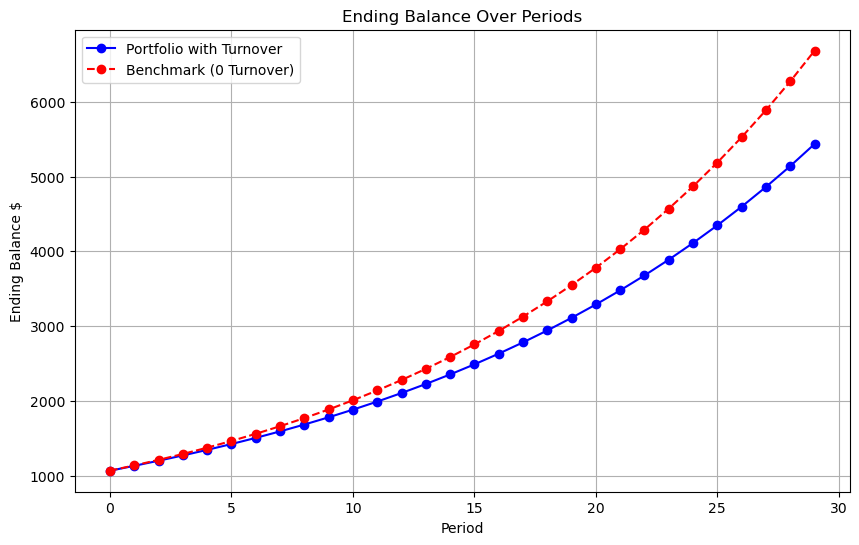

,Beginning Balance,Investment Return,Dividend Income,Beginning Cost Basis,Realized Gain/Loss,Ending Cost Basis,Tax Cost,Ending Balance,Benchmark Ending Balance (0 Turnover)
0,1000.000000,70.000000,23.100000,1000.000000,5.862500,1024.342500,6.041656,1063.958344,1065.380000
1,1063.958344,74.477084,24.577438,1024.342500,16.141417,1060.145867,8.829781,1129.605647,1135.034544
2,1129.605647,79.072395,26.093890,1060.145867,23.987258,1105.008237,11.035688,1197.642354,1209.243103
3,1197.642354,83.834965,27.665538,1105.008237,30.179707,1157.320375,12.851687,1268.625632,1288.303417
4,1268.625632,88.803794,29.305252,1157.320375,35.263632,1216.028209,14.412481,1343.016945,1372.532694
5,1343.016945,94.011186,31.023691,1216.028209,39.620621,1280.467783,15.812739,1421.215392,1462.268882
6,1421.215392,99.485077,32.830076,1280.467783,43.518778,1350.250621,17.119319,1503.581151,1557.872021
7,1503.581151,105.250681,34.732725,1350.250621,47.147377,1425.184178,18.379784,1590.452048,1659.725694
8,1590.452048,111.331643,36.739442,1425.184178,50.640993,1505.216724,19.628329,1682.155362,1768.238560
9,1682.155362,117.750875,38.857789,1505.216724,54.096295,1590.399250,20.889909,1779.016328,1883.845997


,Benchmark Ending Balance (0 Turnover),Ending Value Difference,Portfolio Annualized After Tax Performance,Benchmark Annualized After Tax Performance,Portfolio Required Breakeven Performance,Portfolio Required Annualized Alpha
Ending Balance,,,,,,
"$5,436.94","$6,685.54","$1,248.60",5.81%,6.54%,7.86%,1.32%


In [31]:
taxill(30, 1000, 1000, 0.33, 0.37, 0.20, 0.07, 0.25)